In [1]:
import pandas as pd
import numpy as np
import os

import data
from common import OUTPUTPATH
from modules.experiments import KFold, GroupKFoldSpecial
STATE = np.random.RandomState(seed=1000)

In [2]:
interpolation = pd.read_csv(os.path.join(OUTPUTPATH, 'interpolation.csv'))
interpolation = interpolation.set_index('Unnamed: 0')
interpolation.index.name = None
interpolation


,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR,0.202688,0.010509,0.215175,0.055519,0.556380,0.043451,0.588246,0.146107,2.251545,0.100844,2.359290,0.414337
GAM,0.036842,0.003132,0.088377,0.033908,0.122612,0.010827,0.270439,0.105647,0.647140,0.038226,1.263058,0.476161
RuleFit,0.013761,0.002088,0.066754,0.033378,0.044968,0.005734,0.207544,0.090273,0.323129,0.010737,1.047064,0.429802
RF,0.000015,0.000080,0.065461,0.026606,0.000058,0.000319,0.199298,0.067024,0.243237,0.003150,1.069053,0.685669


In [3]:
extrapolation = pd.read_csv(os.path.join(OUTPUTPATH, 'extrapolation.csv'))
extrapolation = extrapolation.set_index('Unnamed: 0')
extrapolation.index.name = None
extrapolation

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
Lr_pcc,0.203088,0.011308,0.208413,0.167173,0.562837,0.039831,0.624005,0.437829,2.274070,0.098860,2.761258,2.031499
GAM_pcc,0.040066,0.003470,0.146702,0.173823,0.133519,0.010856,0.376702,0.420958,0.671179,0.051213,2.545130,3.358488
RuFit_pcc,0.011257,0.002541,0.141384,0.184799,0.037851,0.007831,0.337756,0.419485,0.273653,0.030820,2.351826,3.136170
RF_pcc,0.000294,0.000472,0.118843,0.184329,0.000588,0.000943,0.264250,0.388123,0.238704,0.003475,1.640178,1.858515


In [4]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)

In [5]:
def get_full_loss(_train, _test):
    """This is calculate realistic full phase error
    """
    train_uniq, train_cnt = np.unique(data.y[data.y.index.isin(_train)].values, return_counts=True, axis=0)
    _select = train_uniq[list(train_cnt).index(max(train_cnt))]
    
    test_uniq, test_cnt = np.unique(data.y[data.y.index.isin(_test)], return_counts=True, axis=0)
    acc_cnt = 0
    for i in range(len(test_uniq)):
        if (test_uniq[i] == _select).all():
            acc_cnt += test_cnt[i]
    return 1-acc_cnt/sum(test_cnt)

def get_hamming_loss(_train, _test, name):
    """This is calculate realistic hamming loss
    """
    train_uniq, train_cnt = np.unique(data.y[name][data.y[name].index.isin(_train)].values, return_counts=True, axis=0)    
    test_uniq, test_cnt = np.unique(data.y[name][data.y[name].index.isin(_test)], return_counts=True, axis=0)
    _select = train_uniq[list(train_cnt).index(max(train_cnt))]

    acc_cnt = 0
    for i in range(len(test_uniq)):
        if test_uniq[i] == _select:
            acc_cnt += test_cnt[i]
    return 1-acc_cnt/sum(test_cnt)

Below is interpolation unreal and uniformed full phase loss

In [6]:
# interpolation full phase
uniq, cnts = np.unique(data.y.values, return_counts=True, axis=0)
unreal_inter_full_info_error = 1 - max(cnts)/sum(cnts)
inter_full_uninfo_error = 1 - (1/2)**4
print('Interpolation full sphase error base line:\nUnreal inform error:{} \nUninform error:{}'.format(unreal_inter_full_info_error, inter_full_uninfo_error))


Interpolation full sphase error base line:
Unreal inform error:0.5912162162162162 
Uninform error:0.9375


Below is interpolation unreal and uniformed hamming loss

In [7]:
# interpolation hamming loss
unreal_inter_hamming_loss = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    error = 1 - max(cnt)/sum(cnt)
    unreal_inter_hamming_loss.append(error)
unreal_inter_hamming_loss = np.mean(unreal_inter_hamming_loss)
inter_uninfo_hamming_loss = np.mean([0.5, 0.5, 0.5, 0.5])

print('Interpolation average sphases error base line:\nUnreal inform error:{} \nUninform error:{}'.format(unreal_inter_hamming_loss, inter_uninfo_hamming_loss))


Interpolation average sphases error base line:
Unreal inform error:0.27956081081081074 
Uninform error:0.5


Below is extrapolation unreal and uniformed full phase loss

In [8]:
# extrapolation full phase loss
unreal_extra_full_info_error = []
cnt =0
for train, test in GroupKFoldSpecial(len(set(data.comp_ids)), size=20).split(data.x1, data.y, data.comp_ids):
    unreal_extra_full_info_error.append(get_full_loss(train, test))
unreal_extra_full_info_error = np.mean(unreal_extra_full_info_error)
unreal_extra_full_info_error
print('Extrapolation full sphase error base line:\nUnreal inform error:{}'.format(unreal_extra_full_info_error))


Extrapolation full sphase error base line:
Unreal inform error:0.5233630952380952


Below is extrapolation unreal and uniformed hamming loss

In [9]:
# extrapolation hamming loss
unreal_extra_hamming_loss = []
for train, test in GroupKFoldSpecial(len(set(data.comp_ids)), size=20).split(data.x1, data.y, data.comp_ids):
    for each in [data.sphere, data.vesicle, data.worm, data.other]:
        unreal_extra_hamming_loss.append(get_hamming_loss(data.y.index.tolist(), test, each.name))
unreal_extra_hamming_loss = np.mean(unreal_extra_hamming_loss)
print('Interpolation average sphases error base line:\nUnreal inform error:{}'.format(unreal_extra_hamming_loss))

Interpolation average sphases error base line:
Unreal inform error:0.2485863095238095


Negative loglikelihood

In [10]:
import math

def neglikehood(p, y):
    result = (-math.log2(p)*y - (1-y)*math.log2(1-p))
    return (result)

def get_full_logs(_train, _test):
    train_uniq, train_cnt = np.unique(data.y[data.y.index.isin(_train)].values, return_counts=True, axis=0)
    train_uniq = [list(each) for each in train_uniq]
    train_prob = train_cnt/sum(train_cnt)
    
    test_uniq, test_cnt = np.unique(data.y[data.y.index.isin(_test)], return_counts=True, axis=0)
    test_uniq = [list(each) for each in test_uniq]
    logs = 0
    for i in range(len(test_uniq)):
        try:
            indx = train_uniq.index(test_uniq[i])
            logs += -1* test_cnt[i] * math.log2(train_prob[indx])
        except:
            pass
    return logs/sum(test_cnt)

def get_hamming_logs(_train, _test, name):
    train_uniq, train_cnt = np.unique(data.y[name][data.y[name].index.isin(_train)].values, return_counts=True, axis=0)
    train_uniq = train_uniq.tolist()
    train_prob = train_cnt/sum(train_cnt)
    
    test_uniq, test_cnt = np.unique(data.y[name][data.y[name].index.isin(_test)], return_counts=True, axis=0)
    test_uniq = test_uniq.tolist()
    
    logs = 0
    for i in range(len(test_uniq)):
        try:
            indx = train_uniq.index(test_uniq[i])
            logs += -1* test_cnt[i] * math.log2(train_prob[indx])
        except:
            pass
    return logs/sum(test_cnt)

In [11]:
# unrealistic interpolation
uniq, cnt = np.unique(data.y.values, axis=0, return_counts=True)
prob = cnt/sum(cnt)

unreal_inter_full_info_loss = 0
for each in cnt:
    unreal_inter_full_info_loss += -each * math.log2(each/sum(cnt))
unreal_inter_full_info_loss = unreal_inter_full_info_loss/sum(cnt)
print("Interpolation full phase logloss base line:\n Unreal Inform error: ", unreal_inter_full_info_loss)

Interpolation full phase logloss base line:
 Unreal Inform error:  2.5225679165070907


In [12]:
# interpolation average sphase informed
unreal_inter_avg_info_loss = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = max(cnt)/sum(cnt) if uniq[list(cnt).index(max(cnt))] else 1- max(cnt)/sum(cnt)
    
    for indx in range(len(each)):
        unreal_inter_avg_info_loss.append(neglikehood(prob, each[indx]))
unreal_inter_avg_info_loss = np.mean(unreal_inter_avg_info_loss)
print('Interpolation average morphology logloss base line:\nUnreal Inform logloss:{}'.format(unreal_inter_avg_info_loss))


Interpolation average morphology logloss base line:
Unreal Inform logloss:0.7401933665227551


In [13]:
real_extra_full_info_loss = []
for train, test in GroupKFoldSpecial(len(set(data.comp_ids)), size=20).split(data.x1, data.y, data.comp_ids):
    real_extra_full_info_loss.append(get_full_logs(train, test))
real_extra_full_info_loss = np.mean(real_extra_full_info_loss)

extra_full_uninfo_loss = -math.log2(0.5**4)

print('Extrapolation full sphase error base line:\nReal Inform logloss:{} \nUninform logloss:{}'.format(real_extra_full_info_loss, extra_full_uninfo_loss))

Extrapolation full sphase error base line:
Real Inform logloss:2.6554775150876018 
Uninform logloss:4.0


In [14]:
unreal_extra_avg_info_loss = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = max(cnt)/sum(cnt) if uniq[list(cnt).index(max(cnt))] else 1- max(cnt)/sum(cnt)
    
    for indx in range(len(each)):
        unreal_extra_avg_info_loss.append(neglikehood(prob, each[indx]))
unreal_extra_avg_info_loss = np.mean(unreal_extra_avg_info_loss)
print('Extrapolation average sphase error base line:\nReal Inform logloss:{}'.format(unreal_extra_avg_info_loss))

Extrapolation average sphase error base line:
Real Inform logloss:0.7401933665227551


In [15]:
interpolation

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR,0.202688,0.010509,0.215175,0.055519,0.556380,0.043451,0.588246,0.146107,2.251545,0.100844,2.359290,0.414337
GAM,0.036842,0.003132,0.088377,0.033908,0.122612,0.010827,0.270439,0.105647,0.647140,0.038226,1.263058,0.476161
RuleFit,0.013761,0.002088,0.066754,0.033378,0.044968,0.005734,0.207544,0.090273,0.323129,0.010737,1.047064,0.429802
RF,0.000015,0.000080,0.065461,0.026606,0.000058,0.000319,0.199298,0.067024,0.243237,0.003150,1.069053,0.685669


In [16]:
extrapolation

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
Lr_pcc,0.203088,0.011308,0.208413,0.167173,0.562837,0.039831,0.624005,0.437829,2.274070,0.098860,2.761258,2.031499
GAM_pcc,0.040066,0.003470,0.146702,0.173823,0.133519,0.010856,0.376702,0.420958,0.671179,0.051213,2.545130,3.358488
RuFit_pcc,0.011257,0.002541,0.141384,0.184799,0.037851,0.007831,0.337756,0.419485,0.273653,0.030820,2.351826,3.136170
RF_pcc,0.000294,0.000472,0.118843,0.184329,0.000588,0.000943,0.264250,0.388123,0.238704,0.003475,1.640178,1.858515


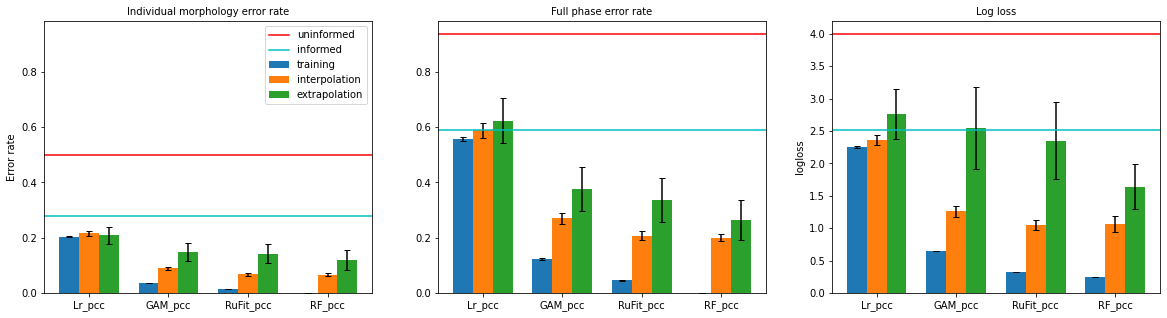

In [17]:
colors = ['r', 'c', 'm', 'y', 'b']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, sharex=True, figsize=(20, 5))

width = 0.25
fontsize = 10
ind = np.arange(len(interpolation))

ax1.bar(ind-width, interpolation[f'mean_train_hamming loss'], width=width, label='training', 
        yerr=interpolation[f'std_train_hamming loss']/30**0.5, capsize=3.0)
ax1.bar(ind, interpolation[f'mean_test_hamming loss'], width=width, label='interpolation',
        yerr=interpolation[f'std_test_hamming loss']/30**0.5, capsize=3.0)
ax1.bar(ind+width, extrapolation[f'mean_test_hamming loss'], width=width, label='extrapolation',
        yerr=extrapolation[f'std_test_hamming loss']/28**0.5, capsize=3.0)

ax1.set_title('Individual morphology error rate', fontsize=fontsize)
ax1.set_xticks(ind)
ax1.set_ylabel('Error rate', fontsize=fontsize)
ax1.set_xticklabels(interpolation.index, fontsize=fontsize)

# add base line
avg_error_base = [inter_uninfo_hamming_loss, unreal_inter_hamming_loss]
avg_error_name = ['uninformed', 'informed']
for i in range(len(avg_error_base)):
    ax1.axhline(y=avg_error_base[i], color=colors[i], linestyle='-', label=avg_error_name[i])

ax1.legend(fontsize=fontsize)
ax1.sharey(ax2) ########### here to share the y axis

ax2.bar(ind-width, interpolation[f'mean_train_error'], width=width, label='training', 
        yerr=interpolation[f'std_train_error']/30**0.5, capsize=3.0)
ax2.bar(ind, interpolation[f'mean_test_error'], width=width, label='interpolation',
        yerr=interpolation[f'std_test_error']/30**0.5, capsize=3.0)
ax2.bar(ind+width, extrapolation[f'mean_test_error'], width=width, label='extrapolation',
        yerr=extrapolation[f'std_test_error']/28**0.5, capsize=3.0)

# add base line
inter_error_base = [inter_full_uninfo_error, unreal_inter_full_info_error]
inter_error_name = ['uninformed', 'informed']
for i in range(len(inter_error_base)):
    ax2.axhline(y=inter_error_base[i], color=colors[i], linestyle='-', label=inter_error_name[i])

ax2.set_title('Full phase error rate', fontsize=fontsize)
ax2.set_xticks(ind)
ax2.set_xticklabels(extrapolation.index, fontsize=fontsize)
ax2.sharey(ax1) ########### here to share the y axis


ax3.bar(ind-width, interpolation[f'mean_train_log loss'], width=width, label='training', 
        yerr=interpolation[f'std_train_log loss']/30**0.5, capsize=3.0)
ax3.bar(ind, interpolation[f'mean_test_log loss'], width=width, label='interpolation',
        yerr=interpolation[f'std_test_log loss']/30**0.5, capsize=3.0)
ax3.bar(ind+width, extrapolation[f'mean_test_log loss'], width=width, label='extrapolation',
        yerr=extrapolation[f'std_test_log loss']/28**0.5, capsize=3.0)

full_loss_base = [4, unreal_inter_full_info_loss]
full_loss_name = ['uninformed', 'informed']
for i in range(len(full_loss_base)):
    ax3.axhline(y=full_loss_base[i], color=colors[i], linestyle='-', label=full_loss_name[i])

ax3.set_title('Log loss', fontsize=fontsize)
ax3.set_xticks(ind)
ax3.set_xticklabels(extrapolation.index, fontsize=fontsize)
ax3.set_ylabel('logloss', fontsize=fontsize)
plt.savefig(os.path.join(OUTPUTPATH, 'overall_performance.pdf'), bbox_inches='tight', pad_inches=0)

plt.show()

In [50]:
df = pd.DataFrame(data.y.iloc[test_indx,].mean()).T


,sphere,worm,vesicle,other
0,0.0,1.0,0.0,0.0


In [43]:
data.y.iloc[test_indx,].mean()

sphere     0.0
worm       1.0
vesicle    0.0
other      0.0
dtype: float64

In [29]:
# extrapolation hold out distribution

from modules.experiments import GroupKFoldSpecial
import data
import pandas as pd

df = pd.DataFrame({'sphere':[], 'worm': [], 'vesicle': [], 'other':[], 'counts':[]})
kf = GroupKFoldSpecial(len(set(data.comp_ids)), size=22)
for train_indx, test_indx in kf.split(data.x1, data.y.replace(-1, 0), groups=data.comp_ids.array):
    temp = pd.DataFrame(data.y.iloc[test_indx,].sum()/sum(data.y.iloc[test_indx,].sum())).T
    temp['counts'] = int(len(test_indx))
    df = pd.concat([df, temp], ignore_index=True)
df = df.round(3)
df = df.astype(str)
df
# df.sphere = df.apply(lambda x: round(x.sphere) if x.sphere == 0 or x.sphere == 1 else x.sphere, axis=1)
# df.loc[1, 'sphere'] = 0.99
# df
# df.round(3)#(0.000000, 0.0)

,sphere,worm,vesicle,other,counts
0,0.241,0.414,0.345,0.0,22.0
1,1.0,0.0,0.0,0.0,16.0
2,0.938,0.0,0.0,0.062,16.0
3,0.5,0.312,0.188,0.0,15.0
4,0.857,0.0,0.0,0.143,14.0
5,1.0,0.0,0.0,0.0,11.0
6,1.0,0.0,0.0,0.0,8.0
7,0.875,0.0,0.0,0.125,8.0
8,1.0,0.0,0.0,0.0,7.0
9,0.222,0.556,0.222,0.0,7.0


In [39]:
df.reindex([10, 1, 5, 6, 8, 11, 12, 14, 15, 19, 24, 25, 26, 27, 28, 21, 22, 23, 18, 20, 0, 2, 3, 4, 7, 9, 13, 16, 17]).reset_index(drop=True)

,sphere,worm,vesicle,other,counts
0,nan,nan,nan,nan,7.0
1,1.0,0.0,0.0,0.0,16.0
2,1.0,0.0,0.0,0.0,11.0
3,1.0,0.0,0.0,0.0,8.0
4,1.0,0.0,0.0,0.0,7.0
5,1.0,0.0,0.0,0.0,7.0
6,1.0,0.0,0.0,0.0,6.0
7,1.0,0.0,0.0,0.0,6.0
8,1.0,0.0,0.0,0.0,6.0
9,1.0,0.0,0.0,0.0,2.0


corona_GMA, core_HEMA has no morphology